In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb
import joblib

# Load the dataset
data = pd.read_csv('data_2013_2016.csv')

# Convert date to datetime format
data['date'] = pd.to_datetime(data['date'])

# Create derived features

# Historical Sales Averages (moving averages over 7, 30, 90 days)
data['7_day_avg_sales'] = data.groupby(['store', 'item'])['sales'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())
data['30_day_avg_sales'] = data.groupby(['store', 'item'])['sales'].transform(lambda x: x.rolling(window=30, min_periods=1).mean())
data['90_day_avg_sales'] = data.groupby(['store', 'item'])['sales'].transform(lambda x: x.rolling(window=90, min_periods=1).mean())

# Sales Seasonality: Extract month, quarter, and year
data['month'] = data['date'].dt.month
data['quarter'] = data['date'].dt.quarter
data['year'] = data['date'].dt.year

# Lagged Sales: 1 day, 7 days, and 30 days lag
data['sales_lag_1'] = data.groupby(['store', 'item'])['sales'].shift(1)
data['sales_lag_7'] = data.groupby(['store', 'item'])['sales'].shift(7)
data['sales_lag_30'] = data.groupby(['store', 'item'])['sales'].shift(30)

# Stock Turnover Ratio
data['stock_turnover_ratio'] = data['sales'] / (data['stock_on_hand'] + 1e-5)  # Avoid division by zero

# Days Until Stockout
data['days_until_stockout'] = data['stock_on_hand'] / (data['7_day_avg_sales'] + 1e-5)

# Days Since Last Restock
data['days_since_last_restock'] = (data['date'] - data.groupby(['store', 'item'])['date'].shift()).dt.days.fillna(0)

# Stock-to-Sales Ratio
data['stock_to_sales_ratio'] = data['stock_on_hand'] / (data['sales'] + 1e-5)

# Supplier Reliability Index (lead time variance)
data['supplier_lead_time_variance'] = data.groupby('supplier_id')['supplier_lead_time'].transform('std').fillna(0)

# Weekend/Weekday Indicator
data['is_weekend'] = data['day_of_week'].apply(lambda x: 1 if x >= 6 else 0)

# Cumulative Sales: Monthly
data['cumulative_sales'] = data.groupby(['store', 'item', 'year', 'month'])['sales'].cumsum()

# Reorder Frequency
data['reorder_frequency'] = data.groupby(['store', 'item'])['restocked_inventory'].transform(lambda x: x.rolling(window=30, min_periods=1).sum())

# Stock Shortage Indicator
data['stock_shortage'] = ((data['stock_on_hand'] < data['stock_reorder_level']) | (data['stock_on_hand'] <= 0)).astype(int)

# Drop rows with missing values generated due to lagging
data.dropna(inplace=True)

# Define features (X) and target variable (sales forecast) (y)
features = [
    'store', 'item', 'supplier_id', 'supplier_lead_time', 'stock_on_hand',
    'stock_reorder_level', 'replenishment_lead_time', 'day_of_week', 'restocked_store',
    'restocked_inventory', '7_day_avg_sales', '30_day_avg_sales', '90_day_avg_sales',
    'month', 'quarter', 'year', 'sales_lag_1', 'sales_lag_7', 'sales_lag_30',
    'stock_turnover_ratio', 'days_until_stockout', 'days_since_last_restock',
    'stock_to_sales_ratio', 'supplier_lead_time_variance', 'is_weekend',
    'cumulative_sales', 'reorder_frequency', 'stock_shortage'
]

X = data[features]
y = data['sales']

# Split data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the XGBoost regressor
xgb_regressor = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.1,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    objective='reg:squarederror'
)

# Train the model
xgb_regressor.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_regressor.predict(X_test)

# Evaluate the model
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)

# Save the trained model
joblib.dump(xgb_regressor, 'xgboost_inventory_model.joblib')

# Output RMSE and MAE
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')


RMSE: 0.5299297794069197
MAE: 0.3464863732959073


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [2]:
import pandas as pd
import joblib

# Load the saved model
xgb_regressor = joblib.load('xgboost_inventory_model.joblib')

# Load the new data for prediction
new_data = pd.read_csv('data_2017.csv')

# Convert date to datetime format if it's not already
new_data['date'] = pd.to_datetime(new_data['date'])

# Re-create derived features on the new dataset
new_data['7_day_avg_sales'] = new_data.groupby(['store', 'item'])['sales'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())
new_data['30_day_avg_sales'] = new_data.groupby(['store', 'item'])['sales'].transform(lambda x: x.rolling(window=30, min_periods=1).mean())
new_data['90_day_avg_sales'] = new_data.groupby(['store', 'item'])['sales'].transform(lambda x: x.rolling(window=90, min_periods=1).mean())
new_data['month'] = new_data['date'].dt.month
new_data['quarter'] = new_data['date'].dt.quarter
new_data['year'] = new_data['date'].dt.year
new_data['sales_lag_1'] = new_data.groupby(['store', 'item'])['sales'].shift(1)
new_data['sales_lag_7'] = new_data.groupby(['store', 'item'])['sales'].shift(7)
new_data['sales_lag_30'] = new_data.groupby(['store', 'item'])['sales'].shift(30)
new_data['stock_turnover_ratio'] = new_data['sales'] / (new_data['stock_on_hand'] + 1e-5)
new_data['days_until_stockout'] = new_data['stock_on_hand'] / (new_data['7_day_avg_sales'] + 1e-5)
new_data['days_since_last_restock'] = (new_data['date'] - new_data.groupby(['store', 'item'])['date'].shift()).dt.days.fillna(0)
new_data['stock_to_sales_ratio'] = new_data['stock_on_hand'] / (new_data['sales'] + 1e-5)
new_data['supplier_lead_time_variance'] = new_data.groupby('supplier_id')['supplier_lead_time'].transform('std').fillna(0)
new_data['is_weekend'] = new_data['day_of_week'].apply(lambda x: 1 if x >= 6 else 0)
new_data['cumulative_sales'] = new_data.groupby(['store', 'item', 'year', 'month'])['sales'].cumsum()
new_data['reorder_frequency'] = new_data.groupby(['store', 'item'])['restocked_inventory'].transform(lambda x: x.rolling(window=30, min_periods=1).sum())
new_data['stock_shortage'] = ((new_data['stock_on_hand'] < new_data['stock_reorder_level']) | (new_data['stock_on_hand'] <= 0)).astype(int)

# Drop rows with missing values generated due to lagging
new_data.dropna(inplace=True)

# Define the feature columns used for predictions
features = [
    'store', 'item', 'supplier_id', 'supplier_lead_time', 'stock_on_hand',
    'stock_reorder_level', 'replenishment_lead_time', 'day_of_week', 'restocked_store',
    'restocked_inventory', '7_day_avg_sales', '30_day_avg_sales', '90_day_avg_sales',
    'month', 'quarter', 'year', 'sales_lag_1', 'sales_lag_7', 'sales_lag_30',
    'stock_turnover_ratio', 'days_until_stockout', 'days_since_last_restock',
    'stock_to_sales_ratio', 'supplier_lead_time_variance', 'is_weekend',
    'cumulative_sales', 'reorder_frequency', 'stock_shortage'
]

# Ensure the new data contains the necessary columns
X_new = new_data[features]

# Perform predictions
new_data['predicted_sales'] = xgb_regressor.predict(X_new)

# Save the new dataset with original and predicted values to a new CSV file
new_data.to_csv('data_2017_with_predictions.csv', index=False)

print("Prediction completed and saved to 'data_2017_with_predictions.csv'.")


Prediction completed and saved to 'data_2017_with_predictions.csv'.


In [3]:
import pandas as pd
import joblib

# Load the saved model
xgb_regressor = joblib.load('xgboost_inventory_model.joblib')

# Load the new data for prediction
new_data = pd.read_csv('data_2017.csv')

# Convert date to datetime format if it's not already
new_data['date'] = pd.to_datetime(new_data['date'])

# Create only the necessary derived features for prediction (without adding them to the CSV)
new_data['7_day_avg_sales'] = new_data.groupby(['store', 'item'])['sales'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())
new_data['30_day_avg_sales'] = new_data.groupby(['store', 'item'])['sales'].transform(lambda x: x.rolling(window=30, min_periods=1).mean())
new_data['90_day_avg_sales'] = new_data.groupby(['store', 'item'])['sales'].transform(lambda x: x.rolling(window=90, min_periods=1).mean())
new_data['month'] = new_data['date'].dt.month
new_data['quarter'] = new_data['date'].dt.quarter
new_data['year'] = new_data['date'].dt.year
new_data['sales_lag_1'] = new_data.groupby(['store', 'item'])['sales'].shift(1)
new_data['sales_lag_7'] = new_data.groupby(['store', 'item'])['sales'].shift(7)
new_data['sales_lag_30'] = new_data.groupby(['store', 'item'])['sales'].shift(30)
new_data['stock_turnover_ratio'] = new_data['sales'] / (new_data['stock_on_hand'] + 1e-5)
new_data['days_until_stockout'] = new_data['stock_on_hand'] / (new_data['7_day_avg_sales'] + 1e-5)
new_data['days_since_last_restock'] = (new_data['date'] - new_data.groupby(['store', 'item'])['date'].shift()).dt.days.fillna(0)
new_data['stock_to_sales_ratio'] = new_data['stock_on_hand'] / (new_data['sales'] + 1e-5)
new_data['supplier_lead_time_variance'] = new_data.groupby('supplier_id')['supplier_lead_time'].transform('std').fillna(0)
new_data['is_weekend'] = new_data['day_of_week'].apply(lambda x: 1 if x >= 6 else 0)
new_data['cumulative_sales'] = new_data.groupby(['store', 'item', 'year', 'month'])['sales'].cumsum()
new_data['reorder_frequency'] = new_data.groupby(['store', 'item'])['restocked_inventory'].transform(lambda x: x.rolling(window=30, min_periods=1).sum())
new_data['stock_shortage'] = ((new_data['stock_on_hand'] < new_data['stock_reorder_level']) | (new_data['stock_on_hand'] <= 0)).astype(int)

# Drop rows with missing values generated due to lagging
new_data.dropna(inplace=True)

# Define the feature columns used for predictions
features = [
    'store', 'item', 'supplier_id', 'supplier_lead_time', 'stock_on_hand',
    'stock_reorder_level', 'replenishment_lead_time', 'day_of_week', 'restocked_store',
    'restocked_inventory', '7_day_avg_sales', '30_day_avg_sales', '90_day_avg_sales',
    'month', 'quarter', 'year', 'sales_lag_1', 'sales_lag_7', 'sales_lag_30',
    'stock_turnover_ratio', 'days_until_stockout', 'days_since_last_restock',
    'stock_to_sales_ratio', 'supplier_lead_time_variance', 'is_weekend',
    'cumulative_sales', 'reorder_frequency', 'stock_shortage'
]

# Ensure the new data contains the necessary columns
X_new = new_data[features]

# Perform predictions
new_data['predicted_sales'] = xgb_regressor.predict(X_new)

# Save only the original columns plus the new 'predicted_sales' column
new_data[['date', 'store', 'item', 'sales', 'predicted_sales']].to_csv('data_2017_with_predictions.csv', index=False)

print("Prediction completed and saved to 'data_2017_with_predictions.csv'.")


Prediction completed and saved to 'data_2017_with_predictions.csv'.


In [4]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
data = pd.read_csv('data_2013_2016.csv')

# Convert date to datetime format
data['date'] = pd.to_datetime(data['date'])

# Feature Engineering
data['month'] = data['date'].dt.month
data['quarter'] = data['date'].dt.quarter
data['year'] = data['date'].dt.year

# Moving Averages to capture trends
data['7_day_avg_sales'] = data.groupby(['store', 'item'])['sales'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())
data['30_day_avg_sales'] = data.groupby(['store', 'item'])['sales'].transform(lambda x: x.rolling(window=30, min_periods=1).mean())
data['90_day_avg_sales'] = data.groupby(['store', 'item'])['sales'].transform(lambda x: x.rolling(window=90, min_periods=1).mean())

# Lag Features to capture recent performance
data['sales_lag_1'] = data.groupby(['store', 'item'])['sales'].shift(1)
data['sales_lag_7'] = data.groupby(['store', 'item'])['sales'].shift(7)
data['sales_lag_30'] = data.groupby(['store', 'item'])['sales'].shift(30)

# Stock Turnover Ratio
data['stock_turnover_ratio'] = data['sales'] / (data['stock_on_hand'] + 1e-5)

# Days Until Stockout
data['days_until_stockout'] = data['stock_on_hand'] / (data['7_day_avg_sales'] + 1e-5)

# Days Since Last Restock
data['days_since_last_restock'] = (data['date'] - data.groupby(['store', 'item'])['date'].shift()).dt.days.fillna(0)

# Stock-to-Sales Ratio
data['stock_to_sales_ratio'] = data['stock_on_hand'] / (data['sales'] + 1e-5)

# Supplier Lead Time Variance
data['supplier_lead_time_variance'] = data.groupby('supplier_id')['supplier_lead_time'].transform('std').fillna(0)

# Weekend/Weekday Indicator
data['is_weekend'] = data['day_of_week'].apply(lambda x: 1 if x >= 6 else 0)

# Cumulative Sales
data['cumulative_sales'] = data.groupby(['store', 'item', 'year', 'month'])['sales'].cumsum()

# Reorder Frequency
data['reorder_frequency'] = data.groupby(['store', 'item'])['restocked_inventory'].transform(lambda x: x.rolling(window=30, min_periods=1).sum())

# Stock Shortage Indicator
data['stock_shortage'] = ((data['stock_on_hand'] < data['stock_reorder_level']) | (data['stock_on_hand'] <= 0)).astype(int)

# Drop rows with missing values due to lag features
data.dropna(inplace=True)

# Feature Columns
features = [
    'store', 'item', 'supplier_id', 'supplier_lead_time', 'stock_on_hand',
    'stock_reorder_level', 'replenishment_lead_time', 'day_of_week', 'restocked_store',
    'restocked_inventory', '7_day_avg_sales', '30_day_avg_sales', '90_day_avg_sales',
    'month', 'quarter', 'year', 'sales_lag_1', 'sales_lag_7', 'sales_lag_30',
    'stock_turnover_ratio', 'days_until_stockout', 'days_since_last_restock',
    'stock_to_sales_ratio', 'supplier_lead_time_variance', 'is_weekend',
    'cumulative_sales', 'reorder_frequency', 'stock_shortage'
]

# Target Columns
target_sales = 'sales'
target_understock = 'stock_shortage'

# Splitting data for sales forecasting
X_sales = data[features]
y_sales = data[target_sales]

# Train-test split
X_train_sales, X_test_sales, y_train_sales, y_test_sales = train_test_split(X_sales, y_sales, test_size=0.2, random_state=42)

# XGBoost for Sales Prediction
sales_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=10, learning_rate=0.1)
sales_model.fit(X_train_sales, y_train_sales)

# Save the sales model
joblib.dump(sales_model, 'xgboost_sales_model.joblib')

# Predict and evaluate Sales
sales_predictions = sales_model.predict(X_test_sales)
rmse = np.sqrt(mean_squared_error(y_test_sales, sales_predictions))
mae = mean_absolute_error(y_test_sales, sales_predictions)

print(f"Sales Forecasting - RMSE: {rmse}, MAE: {mae}")

# Splitting data for understock prediction
X_understock = data[features]
y_understock = data[target_understock]

# Train-test split
X_train_understock, X_test_understock, y_train_understock, y_test_understock = train_test_split(X_understock, y_understock, test_size=0.2, random_state=42)

# XGBoost for Understock Prediction (Classification)
understock_model = xgb.XGBClassifier(n_estimators=100, max_depth=10, learning_rate=0.1)
understock_model.fit(X_train_understock, y_train_understock)

# Save the understock model
joblib.dump(understock_model, 'xgboost_understock_model.joblib')

# Predict and evaluate Understock
understock_predictions = understock_model.predict(X_test_understock)
understock_accuracy = accuracy_score(y_test_understock, understock_predictions)

print(f"Understock Prediction - Accuracy: {understock_accuracy}")

Sales Forecasting - RMSE: 0.7568361404357773, MAE: 0.5165619609757456
Understock Prediction - Accuracy: 1.0


Predicted data saved as 'data_2017_with_predictions.csv'.
Sales Prediction - RMSE: 0.9463906698341623, MAE: 0.6327656639483438
Understock Cases Count: 0
Overstock Cases Count: 147014
Optimal Reorder Points by Product/Store Combination:
store  item
1      1       34.743284
       2       33.716418
       3       34.731343
       4       34.838806
       5       34.498507
                 ...    
10     46      34.205970
       47      34.444776
       48      34.922388
       49      34.316418
       50      34.964179
Name: stock_reorder_level, Length: 500, dtype: float64


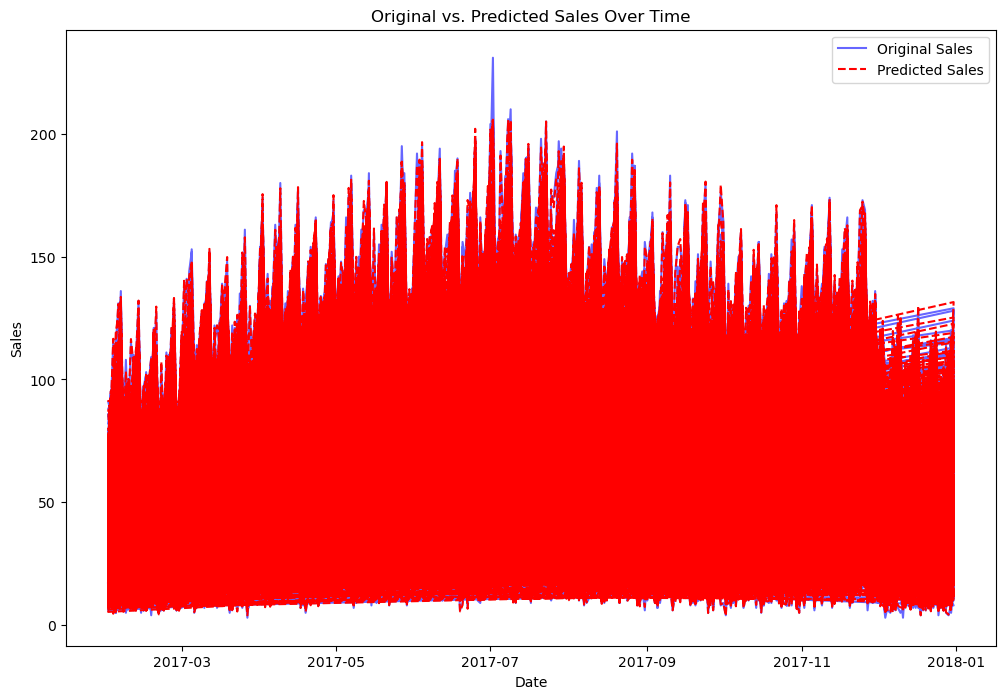

C:\Users\nishi\AppData\Local\Temp\ipykernel_30744\2962325814.py:93: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data_2017, x='understock_risk', palette='coolwarm')


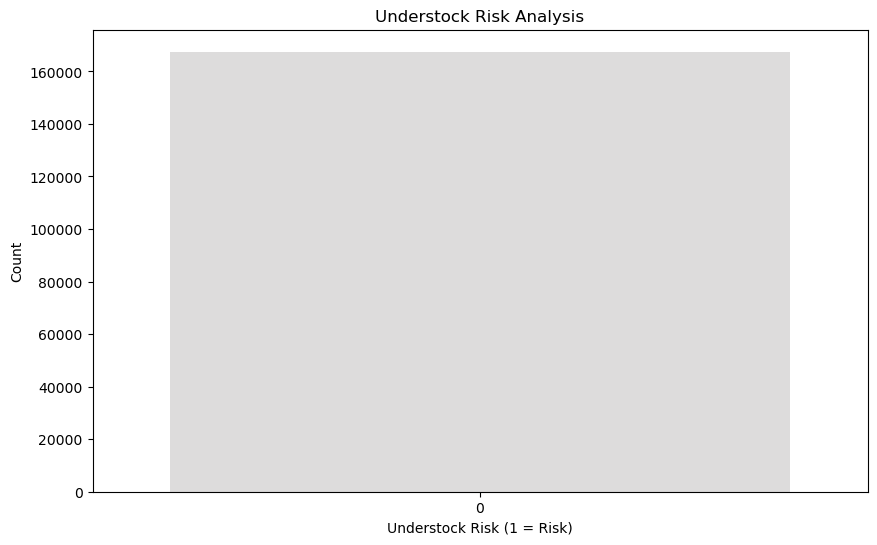

C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


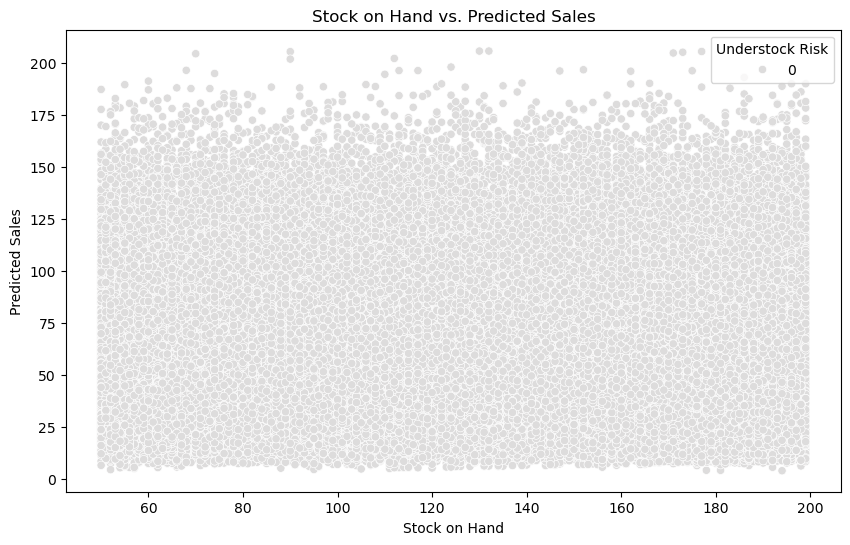

C:\Users\nishi\AppData\Local\Temp\ipykernel_30744\2962325814.py:110: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=data_2017, x='item', y='stock_reorder_level', hue='store', ci=None)


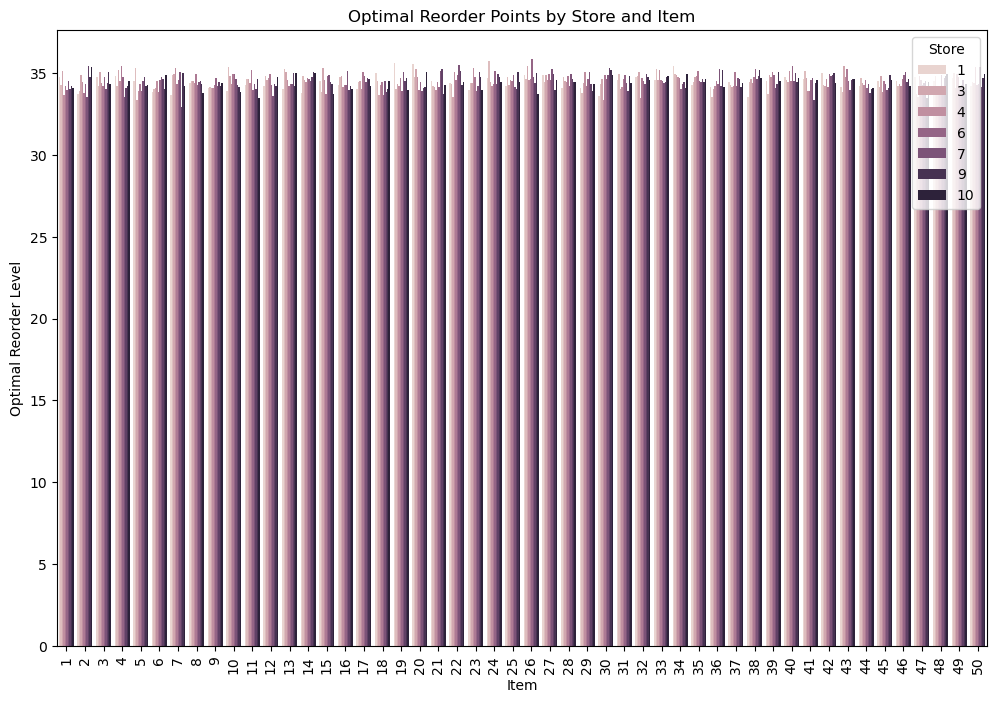

C:\Users\nishi\AppData\Local\Temp\ipykernel_30744\2962325814.py:120: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=data_2017, x='date', y='sales', hue='store', ci=None)


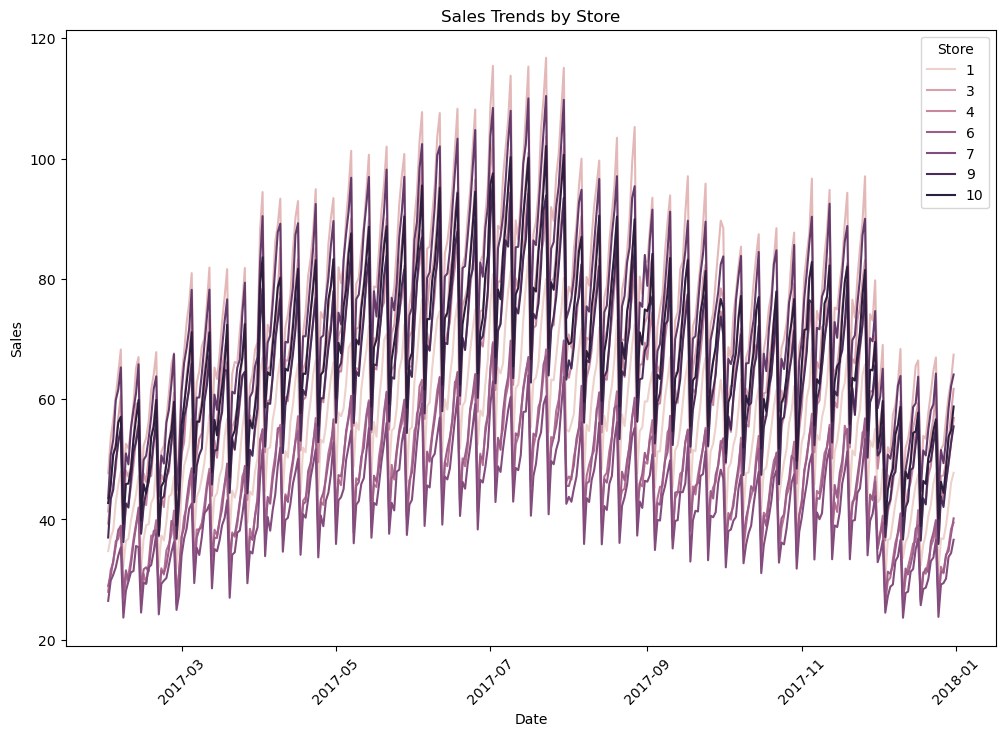

In [5]:
import pandas as pd
import numpy as np
import joblib
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score

# Load saved sales and understock models
sales_model = joblib.load('xgboost_sales_model.joblib')
understock_model = joblib.load('xgboost_understock_model.joblib')

# Load the new dataset
data_2017 = pd.read_csv('data_2017.csv')
data_2017['date'] = pd.to_datetime(data_2017['date'])

# Feature Engineering on new data
data_2017['month'] = data_2017['date'].dt.month
data_2017['quarter'] = data_2017['date'].dt.quarter
data_2017['year'] = data_2017['date'].dt.year
data_2017['7_day_avg_sales'] = data_2017.groupby(['store', 'item'])['sales'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())
data_2017['30_day_avg_sales'] = data_2017.groupby(['store', 'item'])['sales'].transform(lambda x: x.rolling(window=30, min_periods=1).mean())
data_2017['90_day_avg_sales'] = data_2017.groupby(['store', 'item'])['sales'].transform(lambda x: x.rolling(window=90, min_periods=1).mean())
data_2017['sales_lag_1'] = data_2017.groupby(['store', 'item'])['sales'].shift(1)
data_2017['sales_lag_7'] = data_2017.groupby(['store', 'item'])['sales'].shift(7)
data_2017['sales_lag_30'] = data_2017.groupby(['store', 'item'])['sales'].shift(30)
data_2017['stock_turnover_ratio'] = data_2017['sales'] / (data_2017['stock_on_hand'] + 1e-5)
data_2017['days_until_stockout'] = data_2017['stock_on_hand'] / (data_2017['7_day_avg_sales'] + 1e-5)
data_2017['days_since_last_restock'] = (data_2017['date'] - data_2017.groupby(['store', 'item'])['date'].shift()).dt.days.fillna(0)
data_2017['stock_to_sales_ratio'] = data_2017['stock_on_hand'] / (data_2017['sales'] + 1e-5)
data_2017['supplier_lead_time_variance'] = data_2017.groupby('supplier_id')['supplier_lead_time'].transform('std').fillna(0)
data_2017['is_weekend'] = data_2017['day_of_week'].apply(lambda x: 1 if x >= 6 else 0)
data_2017['cumulative_sales'] = data_2017.groupby(['store', 'item', 'year', 'month'])['sales'].cumsum()
data_2017['reorder_frequency'] = data_2017.groupby(['store', 'item'])['restocked_inventory'].transform(lambda x: x.rolling(window=30, min_periods=1).sum())
data_2017['stock_shortage'] = ((data_2017['stock_on_hand'] < data_2017['stock_reorder_level']) | (data_2017['stock_on_hand'] <= 0)).astype(int)

# Drop rows with missing values due to lag features
data_2017.dropna(inplace=True)

# Define the features used for prediction
features = [
    'store', 'item', 'supplier_id', 'supplier_lead_time', 'stock_on_hand',
    'stock_reorder_level', 'replenishment_lead_time', 'day_of_week', 'restocked_store',
    'restocked_inventory', '7_day_avg_sales', '30_day_avg_sales', '90_day_avg_sales',
    'month', 'quarter', 'year', 'sales_lag_1', 'sales_lag_7', 'sales_lag_30',
    'stock_turnover_ratio', 'days_until_stockout', 'days_since_last_restock',
    'stock_to_sales_ratio', 'supplier_lead_time_variance', 'is_weekend',
    'cumulative_sales', 'reorder_frequency', 'stock_shortage'
]

# Predict Sales using the saved model
X_2017 = data_2017[features]
data_2017['predicted_sales'] = sales_model.predict(X_2017)

# Predict Understock Risk using the saved model
data_2017['understock_risk'] = understock_model.predict(X_2017)

# Save the new data with predictions to a CSV file
data_2017[['date', 'store', 'item', 'sales', 'predicted_sales', 'understock_risk']].to_csv('data_2017_with_predictions.csv', index=False)

print("Predicted data saved as 'data_2017_with_predictions.csv'.")

# Summary and Visualization
# Calculate RMSE and MAE for sales predictions
rmse = np.sqrt(mean_squared_error(data_2017['sales'], data_2017['predicted_sales']))
mae = mean_absolute_error(data_2017['sales'], data_2017['predicted_sales'])

print(f"Sales Prediction - RMSE: {rmse}, MAE: {mae}")

# Calculate Understock/Overstock Analysis
understock_cases = data_2017[data_2017['understock_risk'] == 1]
overstock_cases = data_2017[data_2017['stock_on_hand'] > data_2017['predicted_sales']]

optimal_reorder_points = data_2017.groupby(['store', 'item'])['stock_reorder_level'].mean()

print(f"Understock Cases Count: {understock_cases.shape[0]}")
print(f"Overstock Cases Count: {overstock_cases.shape[0]}")
print(f"Optimal Reorder Points by Product/Store Combination:\n{optimal_reorder_points}")

# Visualization
# Plot original vs. predicted sales
plt.figure(figsize=(12, 8))
plt.plot(data_2017['date'], data_2017['sales'], label='Original Sales', color='blue', alpha=0.6)
plt.plot(data_2017['date'], data_2017['predicted_sales'], label='Predicted Sales', color='red', linestyle='--')
plt.title('Original vs. Predicted Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

# Understock vs Overstock analysis
plt.figure(figsize=(10, 6))
sns.countplot(data=data_2017, x='understock_risk', palette='coolwarm')
plt.title('Understock Risk Analysis')
plt.xlabel('Understock Risk (1 = Risk)')
plt.ylabel('Count')
plt.show()

# Scatter plot of Stock vs Predicted Sales
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data_2017, x='stock_on_hand', y='predicted_sales', hue='understock_risk', style='understock_risk', palette='coolwarm')
plt.title('Stock on Hand vs. Predicted Sales')
plt.xlabel('Stock on Hand')
plt.ylabel('Predicted Sales')
plt.legend(title='Understock Risk')
plt.show()

# Optimal Reorder Point Visualization
plt.figure(figsize=(12, 8))
sns.barplot(data=data_2017, x='item', y='stock_reorder_level', hue='store', ci=None)
plt.title('Optimal Reorder Points by Store and Item')
plt.xlabel('Item')
plt.ylabel('Optimal Reorder Level')
plt.legend(title='Store')
plt.xticks(rotation=90)
plt.show()

# Visualization of sales trends
plt.figure(figsize=(12, 8))
sns.lineplot(data=data_2017, x='date', y='sales', hue='store', ci=None)
plt.title('Sales Trends by Store')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend(title='Store')
plt.xticks(rotation=45)
plt.show()
